In [1]:
import numpy as np
import cupy as cp

In [78]:

def zca_whiten(X):
    """
    Applies ZCA whitening to the data (X)
    http://xcorr.net/2011/05/27/whiten-a-matrix-matlab-code/

    X: numpy 2d array
        input data, rows are data points, columns are features

    Returns: ZCA whitened 2d array
    """
    assert(X.ndim == 2)
    EPS = 10e-5
    X = X-np.mean(X,axis=0,keepdims=True)
    #   covariance matrix
    cov = np.dot(X.T, X)
    # cov = np.cov(X)
    #   d = (lambda1, lambda2, ..., lambdaN)
    d, E = cp.linalg.eigh(cp.array(cov))
    print(d)
    #   D = diag(d) ^ (-1/2)
    D = np.diag(1. / np.sqrt(cp.asnumpy(d) + EPS))
    #   W_zca = E * D * E.T
    W = np.dot(np.dot(cp.asnumpy(E), D), cp.asnumpy(E.T))

    X_white = np.dot(X, W)

    return X_white

In [101]:
def zca_whiten_test(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,_ = cp.linalg.svd(cp.array(sigma))
    U = cp.asnumpy(U)
    S = cp.asnumpy(S)
    
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 10e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    xZCAMatrix = np.dot(ZCAMatrix, X)
    return xZCAMatrix


In [126]:
import cv2
 
def read_video(path):
    cap = cv2.VideoCapture(path)
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")
    
    # Read until video is completed
    frames = None
    while(cap.isOpened()):
    # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
           break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, (96,128))
        frame = frame[np.newaxis,:,:].astype(np.float32)/255.0
        frames = frame if frames is None else np.concatenate((frames,frame),axis=0)
    
    cap.release()
    return frames


video_name = "Data_2023-10-22_11-33-39"
frames = read_video('C:/Users/steve/Desktop/809K/data/Data_Test/' + video_name + '.avi')

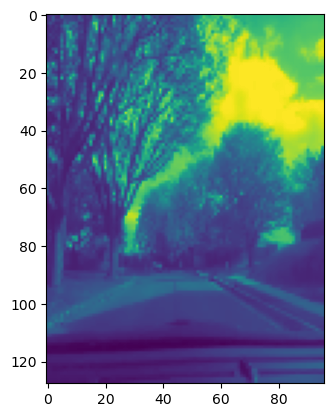

In [91]:
import matplotlib.pyplot as plt

plt.imshow(frames[0,:,:])
plt.show()

In [93]:
frames.shape

(901, 128, 96)

In [92]:
frames1 = np.reshape(frames,(frames.shape[0],-1))

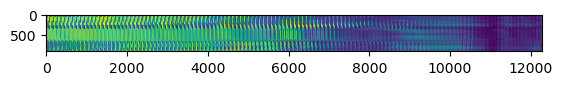

In [94]:
# frames1.shape
plt.imshow(frames1)
plt.show()

In [102]:
frames_w = zca_whiten_test(np.reshape(frames,(frames.shape[0],-1)))

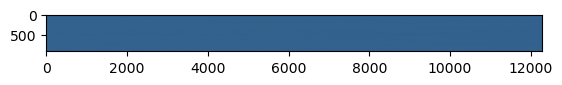

In [112]:
framew_w2 = np.reshape(frames_w,(frames.shape[0],128,96))
plt.imshow(frames_w)
plt.show()

In [113]:
framew_w2[3,:,:].real

array([[ 1.19325532,  0.64226248,  0.32588422, ...,  0.20675017,
         0.0875746 ,  0.07817529],
       [ 0.03162806, -0.12220977, -1.06428884, ...,  0.20960149,
        -0.12454011, -0.06293009],
       [-0.47416998, -0.33907104, -1.0983    , ...,  0.12688221,
        -0.10418619, -0.09078491],
       ...,
       [ 0.11640098,  0.08762695,  0.03191408, ...,  0.22146686,
         0.25754664,  0.29823243],
       [ 0.11319857,  0.09099195,  0.09898897, ...,  0.35825082,
         0.34003354,  0.32201311],
       [ 0.10952663,  0.09152615,  0.10890719, ...,  0.33118094,
         0.36824545,  0.36387657]])

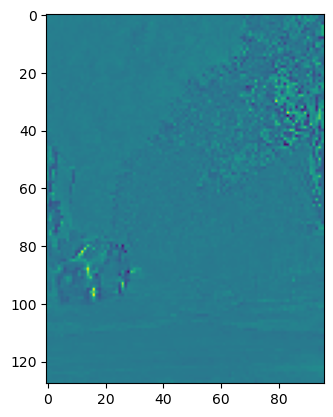

In [127]:
plt.imshow(framew_w2[120,:,:])
plt.show()

# cv2.imshow('test', framew_w2[1,:,:]) 
# cv2.waitKey(0) 


In [128]:
from tqdm import tqdm

frame_width = 96
frame_height = 128
frame_size = (frame_width, frame_height) 


save_clip = cv2.VideoWriter(video_name + '_ZCA.avi',  cv2.VideoWriter_fourcc(*'MJPG'), 10, frame_size, isColor=False) 

for i in tqdm(range(framew_w2.shape[0])):
    image = framew_w2[i,:,:]
    # print(image.shape)
    save_clip.write(image)
    
save_clip.release()

100%|██████████| 901/901 [00:00<00:00, 5951.05it/s]
